# Lab 4: GPs for Big Data

_written by Fariba Yousefi, Juan José Giraldo, and Wil Ward, adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/), [Neil Lawrence](http://inverseprobability.com/), and [James Hensman](http://jameshensman.github.io/)_

The concept of sparse methods for Gaussian process regression is introduced for creating a scalable regression model, and this is combined with a large classification problem.

As with Lab 1, the notebook uses `GPy` for handling the regression model and likelihoods.

##  1. Getting started

You should be using Python 3.5 (or above), and have `GPy` installed.

First we setup our notebook with the libraries we are going to use. As with Lab 1, we use `numpy` for maths functionality, `pyplot` for plotting, and `GPy` for Gaussian processes.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

We will recycle our GP plotting utility from Lab 1:

In [2]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

---
## 2. Sparse Gaussian Processes

The non-parametric formulation that characterises Gaussian processes makes the cost of inference prohibitive when the number of data observations is large. The computational cost of inference is $\mathscr{O}(N^3)$, where $N$ is the number of observations, for full GP regression, as a result of matrix inversions required to calculate the posterior. In order to deal with this, an augmentation of the GP regression model called _sparse GPs_ aims to use a small set of _inducing variables_ to approximate the probability space. The driving idea is to find a posterior over the smaller set of $M (\ll N)$ inducing variables instead of over $N$ training points to reduce the computational requirements. The challenge, then, is to find the set of inducing variables and model parameters that best approximate the full GP.

In the following example, we will explicitly be working with Gaussian likelihoods again, to introduce the concept of sparse approximation in a simple setting. It is possible to extend sparse GPs to non-Gaussian likelihoods, which we will discuss at the end of this notebook.

### Full versus Sparse Gaussian Process Regression

In the following example, we will simulate some observations sampled from a GP, and compare the results of sparse and full regression.

First we will generate $N=50$ samples from a GP:

In [3]:
# This is important for reproducing the latent function
np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Create a smooth GP latent function
X = np.sort(np.random.rand(50, 1), 0)
y = np.random.multivariate_normal(np.zeros(50), k.K(X,X) + 0.01*np.eye(50))[:, None]

While $N=50$ is not a _huge_ number of data, this example will show that we can get a reasonably accurate fit with only a small number of inducing variables, $M=3$. This will reduce the complexity of full GP regression, $\mathscr{O}(N^3)$, to $\mathscr{O}(NM^2)$, which is clearly a useful reduction in computational requirements &ndash; even in this basic example, we can see $450 \ll 125000$.

We make use of the `SparseGPRegression` model which, like the `GPRegression` model, has sensible defaults that we don't need to worry about for this example. The `SparseGPRegression` assumes a Gaussian likelihood and uses exact Gaussian inference. We could also define these explicitly using `core.SVGP`, which is the sparse equivalent of `core.GP` that we used above, allowing us to define the inference method, and likelihood.

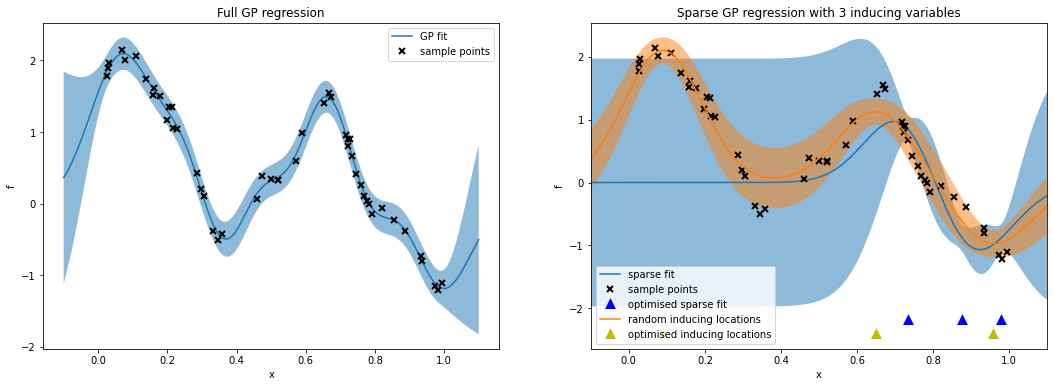

In [7]:
# Our sample space for predictions from the posterior
Xnew = np.linspace(-0.1, 1.1, 1000)[:, None]

# The covariance we used to generate the samples (assumed)
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))

plt.subplot(121)
## First we fit with full GP regression 
m = GPy.models.GPRegression(X, y, kernel=k)
m.Gaussian_noise.variance = 0.01

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, y))
plt.title("Full GP regression")


plt.subplot(122) 
## Next, we define M=3 inducing points randomly within the sample space
Z = np.random.rand(3, 1)

# We fit with sparse GP regression using randomly assigned inducing variables
m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
m.Gaussian_noise.variance = 0.01
m.Gaussian_noise.fix() # We fix the Gaussian observation noise

# We will not optimise any of the hyperparameters again
mean_sparse_rand, Cov_sparse_rand = m.predict(Xnew, full_cov=True)

# Plot the posterior of the likelihood fit using a sparse GP
plot_gp(Xnew, mean_sparse_rand, Cov_sparse_rand, training_points=(X, y))
# Plot the randomly assigned inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'b^', mew=3)
         
## We are now going to optimise the model
# We will optimise the inducing point locations and the 
# .. kernel hyperparameters with respect to each other (remember the noise is fixed)
m.optimize()

# We predict the optimised sparse GP fit
mean_sparse_opt, Cov_sparse_opt = m.predict(Xnew, full_cov=True)

# We plot our new mean
plot_gp(Xnew, mean_sparse_opt, Cov_sparse_opt)
# Plot optimised inducing variable locations
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'y^', mew=3)

# Annotate plot
plt.xlim((-0.1, 1.1)), plt.title("Sparse GP regression with 3 inducing variables")
plt.legend(labels=["sparse fit", "sample points", "optimised sparse fit", "random inducing locations", "optimised inducing locations"]);

With such a small number of data points, it's clearly a better option to use full Gaussian process regression here. However, our optimised sparse GP fit produces a sufficiently good fit of the data considering the small ($M=3$) number of inducing variables used. It should be clear that when we have a substantially larger number of data points $N$, using sparse GPs will provide a scalable solution when it is no longer feasible to calculate the full GP.

### A Longer Example

In the next example, we will try and use sparse GPs to approximate an unknown function for which we have a large number of (noisy) observations.

Consider the function
$$
    f(x) = \sin(2\pi x) + \sin(25\pi x) + \sin(5\pi x) + \sin(11\pi x)
$$

We have a large number of observations, $N=5000$:

$$
    \mathbf{y} = f(\mathbf{X}) + \varepsilon,
$$

and for now, we will assume a Gaussian likelihood: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$

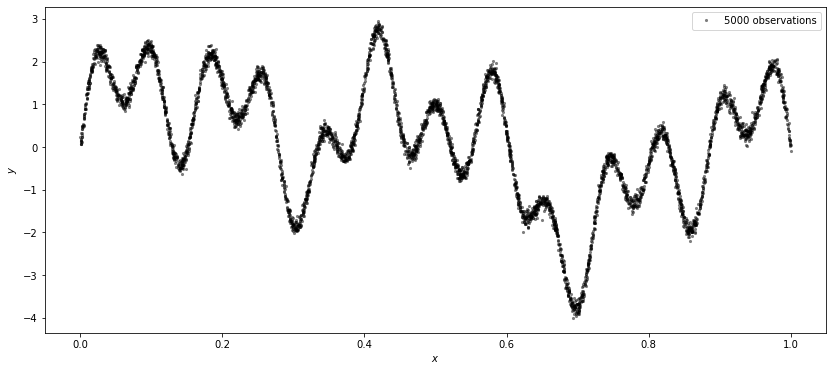

In [8]:
# True latent function
f = lambda x: sum([np.sin(w*np.pi*x) for w in [2, 25, 5, 11]])

N = 5000 # large number of observations

# Random sample locations
X = np.sort(np.random.rand(N)[:,None])
# N noisy observations of the latent function with variance 0.01
y = f(X) + 0.1*np.random.randn(N, 1)

#== Plot samples
plt.figure(figsize=(14, 6))

# Plot points (since there's a lot we make them slightly transparent)
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$")
plt.legend(labels=["%d observations" % N]);

Clearly, if we tried to fit full GP regression to this, we would face some problems with the sheer computational resources required for matrix inversion in the Gaussian process equations.

We will use a sparse GP with a small number of inducing points, $M=20$, to try and fit the function. Given the large number of points, we will make some adjustments of the optimiser. We will cap the number of iterations to save time in the lab. These options are given to the `m.optimize()` function. We also add a small amount ($\sigma^2=10^{-6}$) of white noise to our kernel function to avoid any ill-posedness that may occur in the matrix calculations.

In [9]:
# Number of inducing variables
M = 20

# We define M inducing variables sampled uniformly throughout our input space
Z = np.linspace(0., 1., M)[:, None]

# We assume the covariance to be an RBF, and add a white noise term for numerical stability
k = GPy.kern.RBF(1, lengthscale=0.05, name="rbf") + GPy.kern.White(1, name="white")

# Define a sparse GP with Gaussian likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel = k,
    likelihood = GPy.likelihoods.Gaussian()
)

# We define the white noise variance to 10^-6 and fix this
m.kern.white.variance = 1.e-6
m.kern.white.fix()

# We limit the number of iterations here, to limit the maximum runtime
# .. We will also allow the optimiser to print progress messages while it is running
m.optimize(max_iters=2500, messages=1)

# Preview our sparse GP model
m

SVGP.,value,constraints,priors
inducing inputs,"(20, 1)",,
sum.rbf.variance,0.2435632558360065,+ve,
sum.rbf.lengthscale,0.05245961313548569,+ve,
sum.white.variance,1e-06,+ve fixed,
Gaussian_noise.variance,0.4958867527120048,+ve,
q_u_chol,"(210, 1)",,
q_u_mean,"(20, 1)",,


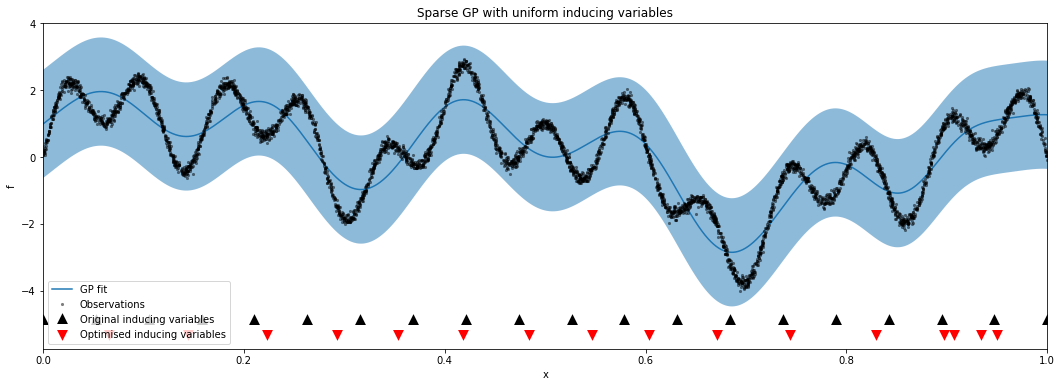

In [10]:
# We create a prediction space defined over the observation space
Xnew = np.linspace(0., 1., 2000)[:, None]

# We predict a likelihood free estimate of our latent functon
mean, Cov = m.predict(Xnew)

# Set up figure environment
plt.figure(figsize=(18, 6))

# Plot the sparse GP prediction
plot_gp(Xnew, mean, Cov)

# Plot observations
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
# .. Original inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'k^', mew=3)
# .. Optimised inducing variables
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)

# Annotate plot
plt.xlim((0., 1.))
plt.title("Sparse GP with uniform inducing variables")
plt.legend(labels=["GP fit", "Observations", "Original inducing variables", "Optimised inducing variables"]);

### Exercise 1

(a) How do you feel about the fit? Based on what you learned in the Lab 1, what changes might you make to the kernel used?

(b) In the above example, we sampled the inducing variable locations uniformly. However, we can produce a better initialisation, for example using $k$-means clustering. Using `scipy.cluster.vq.kmeans`, initalise the inducing point based on the cluster centroids. How does this improve the fit?

In [11]:
from scipy.cluster.vq import kmeans

## 3. Sparse GPs with Non-Gaussian Likelihoods
In the case of sparse regression of functions with a Gaussian likelihood, it is a relatively straightforward computation to calculate the posterior of a GP fit. However, for sparse approximation of non-Gaussian likelihoods, we must rely on sampling or quadrature methods to approximate the expectations. Luckily, with `GPy`, we can perform these approximations using a combination of the same routines that we have used previously.

We will first load up a dataset for a binary classification problem in 2-D. The data has a large number of observations, occuring in a complex geometry. We use the _Banana_ dataset as our classification problem. By default, the categories are labeled $-1$ and $1$, but we will map these to $[0, 1]$ so we can model the classification problem with a Bernoulli likelihood.

Data Source: _J. Alcalá-Fdez, A. Fernandez, J. Luengo, J. Derrac, S. García, L. Sánchez, F. Herrera. KEEL Data-Mining Software Tool: Data Set Repository, Integration of Algorithms and Experimental Analysis Framework. Journal of Multiple-Valued Logic and Soft Computing 17:2-3 (2011) 255-287_

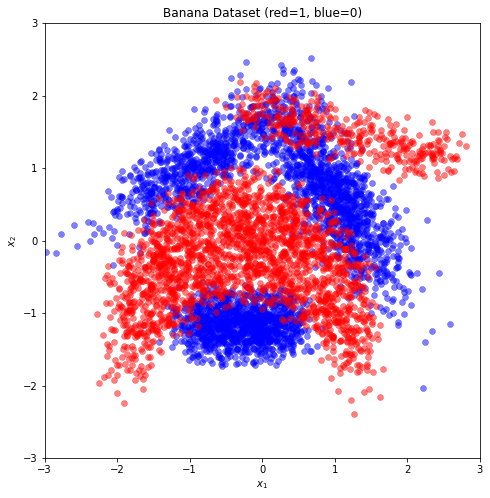

In [12]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1

# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], (0.5 + data[:,-1]/2)[:, None]

# We will plot our data as well
plt.figure(figsize=(8,8))

# Plot 0 class in blue
plt.plot(X[np.where(y == 0),0],X[np.where(y == 0),1],'bo', mew=0.5, alpha=0.5)
# Plot 1 class in red
plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1],'ro', mew=0.5, alpha=0.5)

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Banana Dataset (red=1, blue=0)")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3));

We will use our sparse GP framework with the `core.SVGP` object in `GPy`. For now, we will just use an anisotropic `RBF` kernel with some fixed white noise, again $\sigma^2=10^{-6}$. We use a Bernoulli likelihood with a probit link function, as in our previous examples, though we alternatively could try a sigmoid, or other link functions for this problem.

Because we are using a sparse approximation, we are already making approximating the likelihood using a variational model. As a result, we don't need to specify our inference model, such as Laplace approximation. We will also use the density information to guide our inducing variable locations: we fit $k$-means and take the centroids as _fixed_ locations to save the optimiser some work. For now, we will use $M=8$ inducing variables.

In [13]:
# Number of inducing points
M = 8

# Our inducing variables, assigned with k-means
Z = 1. * kmeans(X, M)[0]

# We use a 2-D anisotropic RBF kernel here, to allow us different lengthscales in each direction
k = GPy.kern.RBF(D, active_dims=[0, 1], ARD=True) + GPy.kern.White(D, variance=1.e-6)

# Bernoulli likelihood
B_dist  = GPy.likelihoods.Bernoulli()

# Fit a sparse variational Gaussian process our data, inducing points and a Bernoulli likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel = k,
    likelihood = B_dist
)
# We will fix the white noise of our kernel to 10^-6
m.kern.white.fix()
# We will also fix the locations of the inducing variables to the k-means fit
m.Z.fix()

# Optimise the hyperparameters and variational model
m.optimize(max_iters=2500, messages=1)
# Preview model
m

SVGP.,value,constraints,priors
inducing inputs,"(8, 2)",fixed,
sum.rbf.variance,0.21362250641134226,+ve,
sum.rbf.lengthscale,"(2,)",+ve,
sum.white.variance,1e-06,+ve fixed,
q_u_chol,"(36, 1)",,
q_u_mean,"(8, 1)",,


We want to look at the classifer created by our regression fit. The best way to do this is to model the probability surface of the Bernoulli likelihood. This is defined as our latent function approximated through the probit transform, and serves as a good representation of classifer. We will also plot the _median_ of the Bernoulli likelihood, as we did in the 1-D example, which gives us a good point estimate of a decision boundary.

Remember, we can calculate the variance of a Bernoulli distribution with $p(1-p)$, where $p$ is our squashed mean latent function that serves as the probability of the likelihood.

We will define a prediction space over $[-3, 3] \times [-3, 3]$:

In [15]:
Xi, Xj = np.meshgrid(np.linspace(-3., 3., 100), np.linspace(-3., 3., 100))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean of the likelihood, which serves as our Bernoulli probability
prob, _ = m.predict(Xnew2, include_likelihood=True)
# Define a decision boundary by finding the median (the point where the probability switches between >0.5 and <0.5)
quantiles = m.predict_quantiles(Xnew2, quantiles=np.array([50.]), likelihood=m.likelihood)

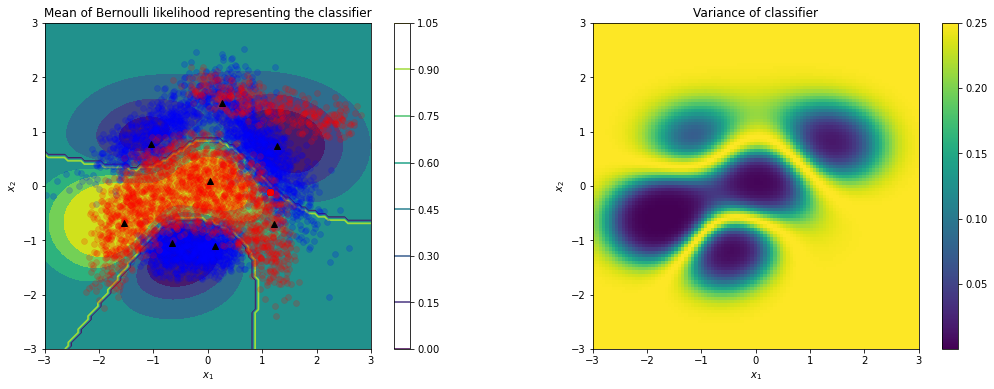

In [16]:
# Create our figure environment
plt.figure(figsize=(18,6))

#### We plot first the probability of our Bernoulli likelihood
plt.subplot(121)

# Plot the mean likelihood
plt.contourf(Xi, Xj, prob.reshape(Xi.shape))
# Plot the median of the predicted likelihood
plt.contour(Xi, Xj, quantiles[0].reshape(Xi.shape))

# Plot the data points
plt.plot(X[np.where(y == 0),0],X[np.where(y == 0),1],'bo', mew=0.5, alpha=0.2)
plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1],'ro', mew=0.5, alpha=0.2)

# Plot the inducing variables
plt.plot(Z[:,0], Z[:,1],'k^')

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3))
plt.title("Mean of Bernoulli likelihood representing the classifier")
plt.colorbar();

#### We will also plot the variance of the classifer
plt.subplot(122)
# We can extract the variance from our mean function estimation of the Bernoulli distribution. 
plt.pcolor(Xi, Xj, (prob*(1.-prob)).reshape(Xi.shape))

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of classifier")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3))
plt.colorbar();

### Exercise 2

In this example, we preset the number of inducing points to $M=8$ and fixed their positions to the centroids of a $k$-means clustering. Try experimenting with using random initialisation, optimisation of inducing point locations, and changing the number of inducing points. How does this affect the accuracy of the model, and the time it takes to infer a posterior?